# Quantum Simulation using VQE
## Apurva Tiwari
### Problem: Find inter-atomic distance of LiH molecule. Explain molecular Hamiltonian.

## Introduction
(All symbols have usual meanings from quantum mechanics.)

### To find: Interatomic distance of given molecule using VQE

Implies, find groundstate energy corresponding to an array of potential distances, and choose minimum.

Formally, for a given Hermitian matrix $H$, and an unknown minimum eigenvalue $\lambda_{\text{min}}$, use VQE to estimate  bound $\lambda_{\text{min}}$:

$$
\begin{aligned}
    \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{aligned}  
$$

where $|\psi(\theta)\rangle$ is the eigenstate corresponding to $\lambda_{\theta}$, parameterized by $\theta$.

## The Variational Method of Quantum Mechanics

### Mathematical Background


Spectral decomposition of Hermitian $H$,
$$
\begin{aligned}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{aligned}
$$

The expectation value of the observable $H$ on quantum state $|\psi\rangle$ is given by,

$$
\begin{aligned}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{aligned}
$$

Thus on substitution,

$$
\begin{equation}
    \langle H \rangle_{\psi} = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{equation}
$$


Therefore, the expectation value of an observable on a given state can be represented as a linear combination with the eigenvalues as weights. 

The variational method:
$$
\begin{aligned}
    \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$

### Bound on the Groundstate

Selecting an ansatz to begin with, and iteratively updating it, an expectation value $\langle H \rangle_{\psi}$ is computed, and arbitrarily tight bounds on the groundstate energy (smallest eigenvalue) can be obtained.

## Molecular Hamiltonian

The molecular Hamiltonian represents the total energy consisting of the kinetic and potential energy, given by,

$$
\begin{equation}
\hat{\mathcal{H}} = \hat{T} +\hat{V}
\end{equation}
$$
where potential energy is due to the Coulombic interactions between various particles. Inter-atomic neutrons and protons are considered a single body as the nucleus. These include electron-electron repulsion, nuclei-nuclei repulsion and electron-nuclei attraction.

$$
\begin{equation}
\hat{V}=\sum_{i,j}^e\frac{e^2}{4\pi\epsilon_0|\sigma_i-\sigma_j|}+\sum_{i,j}^n\frac{Z_iZ_je^2}{4\pi\epsilon_0|\sigma_i-\sigma_j|}-\sum_i^e\sum_j^n\frac{Z_je^2}{4\pi\epsilon_0|\sigma_i-\sigma_j|}
\end{equation}
$$

First two terms represent repulsions and the third attraction (so, -ve). Z is the atomic number to scale the charge appropriately.
The kinetic energy is given as,

$$
\begin{equation}
\hat{T}=-\sum_i^n\frac{\hbar^2}{2m_i}-\sum_i^n\frac{\hbar^2}{2m_e}
\end{equation}
$$



## Born-Oppenheimer Approximation
approximates the nuclei to be stationary relative to the electrons as they the time-scales differ by multiple orders of magnitude.
This means that the kinetic energy contribution from the nuclei goes to zero.

$$
\begin{equation}
\hat{T}=-\sum_i^n\frac{\hbar^2}{2m_e}
\end{equation}
$$

and the potential energy contribution from the nuclei-nuclei repulsion term, is a constant.

$$
\begin{equation}
\hat{V}=\sum_{i,j}^e\frac{e^2}{4\pi\epsilon_0|\sigma_i-\sigma_j|}+C-\sum_i^e\sum_j^n\frac{Z_je^2}{4\pi\epsilon_0|\sigma_i-\sigma_j|}
\end{equation}
$$

This gives the electronic Hamiltonian.

### Note:
`GroundStateEigensolver` used in following cells, post-processes results to add the nuclei contribution to give the total energy.

### Deprecation note: 
Qiskit Nature's v0.5 release (current) is not entirely backwards compatible. Most available references/tutorials etc. available use the deprecated Qiskit Nature v0.4, with some modules from Qiskit Aqua.

In [2]:
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

# Initializing molecule

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

def initialize_problem(dist,molecule):
    driver = PySCFDriver(
    atom=molecule.format(dist),
    basis='sto3g',
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
    )
    
    problem = driver.run()
    if problem.molecule.symbols[0]=='Li':
        # reduce problem size with two qubit and orbital reduction
        transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[-3,-2])
        problem = transformer.transform(problem)
        
    
    return problem

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Map physical operators to qubit space
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter
converter = QubitConverter(JordanWignerMapper())

In [4]:
# Numpy solver for reference
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
numpy_solver = NumPyMinimumEigensolver()

### VQE solver
The new qiskit nature has a `VQEUCCFactory` constructor that returns a `VQE` object,
with input ansatz (default: `HartreeFock` state) and optimizer.


In [5]:
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD

vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())

In [6]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
calc_vqe = GroundStateEigensolver(converter, vqe_solver)

### Compute groundstate energies corresponding to an array of inter-atomic distances

In [8]:
import numpy as np

# Define molecule
molecule='Li 0 0 0; H {} 0 0' # Switch to H2 molecule for faster results

distances=np.arange(0.5,4.25,0.25) # reduce resolution for run cell faster
#distances=np.array([0.5])
exact_energies=[]
vqe_energies=[]

calc_numpy = GroundStateEigensolver(converter, numpy_solver)
calc_vqe = GroundStateEigensolver(converter, vqe_solver)


for i, dist in enumerate(distances):
    es_problem=initialize_problem(dist,molecule)
    res_numpy = calc_numpy.solve(es_problem)
    res_vqe = calc_vqe.solve(es_problem)
    exact_energies.append(res_numpy.total_energies[0].real)
    vqe_energies.append(res_vqe.total_energies[0].real)

In [9]:
# Find distance with the least total groundstate energy

min_energy=np.min(vqe_energies)
min_dist=distances[np.where(vqe_energies == min_energy)]
print("Inter-atomic distance (in Angstrom) = ", min_dist[0])

Inter-atomic distance (in Angstrom) =  1.5


In [ ]:
print(res_vqe)

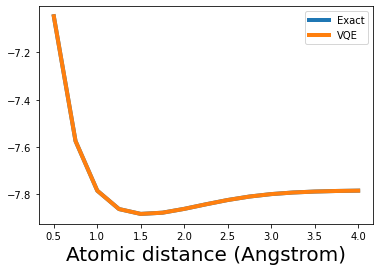

In [12]:
# Compare result with reference

import matplotlib.pyplot as plt

plt.plot(distances,exact_energies,label='Exact',linewidth=4)
plt.plot(distances,vqe_energies,label='VQE',linewidth=4)
plt.xlabel('Atomic distance (Angstrom)',fontsize=20)
#plt.ylabel('Energy (Hartree)',fontsize=20)
plt.legend()
plt.show()

In [13]:
plt.savefig('VQE_result.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>